In [9]:
import torch
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize([0.5], [0.5]),
                               ])
# # Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
# trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# # Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Visualization of input data

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

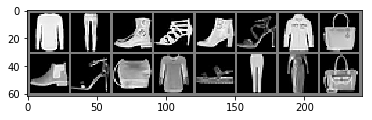

Pullover Trouser Ankle boot Sandal Ankle boot Sandal  Coat   Bag Ankle boot Sandal   Bag Shirt Sandal Trouser Dress   Bag


In [12]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# connect integer labels with English words
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# convert tensors to grid and pass to plot function
imshow(torchvision.utils.make_grid(images[0:16]))

# add list of labels for pictures from top left to bottom right
print(' '.join('%5s' % class_names[labels[j]] for j in range(16)))

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Train = (pd.read_csv('data/fashion-mnist_train.csv')).values
Test  = (pd.read_csv('data/fashion-mnist_test.csv')).values

In [14]:
X_train, Y_train = Train[:,1:Train.shape[0]], Train[:,0]
X_test, Y_test = Test[:,1:Test.shape[0]], Test[:,0]

In [15]:
X_train2d = np.zeros([X_train.shape[0], 28, 28])
print(X_train2d.shape)

(60000, 28, 28)


In [16]:
#todo: vectorize
X_train2d = np.zeros([X_train.shape[0], 28, 28])
for index, x in enumerate(X_train):
    X_train2d[index] = x.reshape(28, 28)

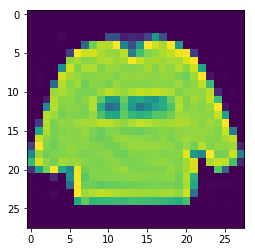

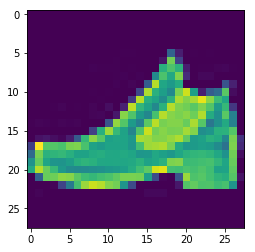

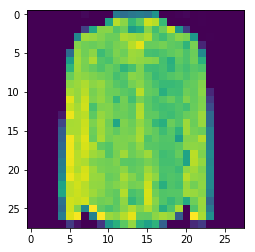

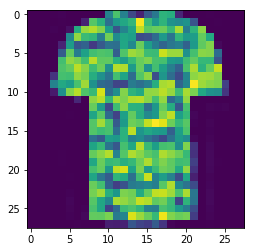

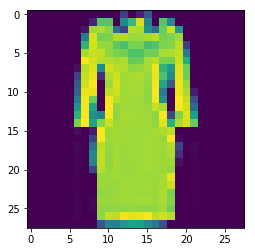

In [9]:
for i in range(5):
    plt.figure()
    plt.imshow(X_train2d[i])

In [17]:
# images are here 2d numpy arrays!
def rotate_img(img, rot):
    if rot == 0:
        rotatedImage = img
    if rot == 90:
        rotatedImage = np.fliplr(np.transpose(img))
    if rot == 180:
        rotatedImage = np.fliplr((np.flipud(img)))
    if rot == 270:
        rotatedImage = np.flipud(np.transpose(img))
    return rotatedImage

In [18]:
# set of possible rotations
rot = [0, 90, 180, 270]
    
# initialize new training dataset for rotated images
X_train2dRot = np.zeros([X_train2d.shape[0]*4, X_train2d.shape[1], X_train2d.shape[2]])
print(X_train2dRot.shape)

# rotate all images in four directions
rotInx = 0
for rotVal in rot:
    for imgInx, i in enumerate(X_train2d):
        X_train2dRot[rotInx] = rotate_img(X_train2d[imgInx], rotVal)
        rotInx += 1

(240000, 28, 28)


In [19]:
# training labels matrix for all rotations

y = np.array([0, 90, 180, 270])
noOfImg = X_train2d.shape[0]
Y_trainRotLabels = np.repeat(y, noOfImg)
print(Y_trainRotLabels.shape)
print(Y_trainRotLabels)

(240000,)
[  0   0   0 ... 270 270 270]


0
90
180
270


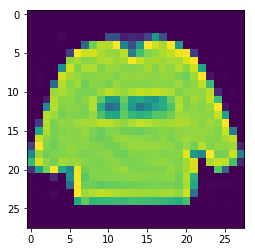

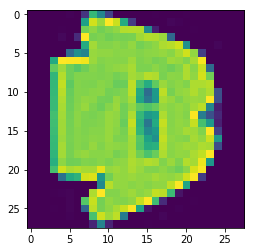

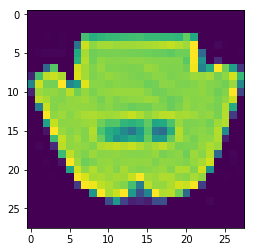

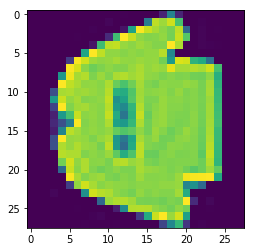

In [13]:
index = (0, 60000, 120000, 180000)

for i in index:
    plt.figure()
    plt.imshow(X_train2dRot[i])
    print(Y_trainRotLabels[i])

In [20]:
# make dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(X_train2dRot, batch_size=32, shuffle=False, num_workers=4)

In [25]:
print(len(train_dataloader.dataset))
print(X_train2dRot.shape)

240000
(240000, 28, 28)


In [33]:
import time
from torch.autograd import Variable

def train(model, loss_fn, optimizer, scheduler, num_epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataloader = None
    dataset_size = 0
    
    for epoch in range(num_epochs):
        since = time.time()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        
        # Each epoch has a training and validation phase
        #for phase in ['train', 'val']:
        for phase in ['train']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = len(train_dataloader.dataset)
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = train_dataloader
                dataset_size = len(train_dataloader.dataset)

                
            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            
            for data in dataloader:
                # get the inputs
                
                print(len(data))
                print(data)
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = loss_fn(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data).to(torch.float32)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
import torch
import torch.nn as nn
from torch.autograd import Variable


def flatten(x): 
    return x.view(x.size(0), -1)


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)



class BasicBlock(nn.Module):

    expansion = 1       

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(in_planes, planes, stride)
        self.conv2 = conv3x3(planes, planes)

        self.bn1 = nn.BatchNorm2d(planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

        self.stride = stride

    def forward(self, x):

        residue = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            residue = self.downsample(x)

        out += residue
        out = self.relu(out)
        return out


class Bottleneck(nn.Module):
    
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.downsample = downsample
        
        self.stride = stride
        
    def forward(self, x):

        residue = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(x)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            residue = self.downsample(x)

        out += residue
        out = self.relu(out)
        return out
            
            
class ResNet(nn.Module):

    def __init__(self, depth, name, num_classes=10, block=BasicBlock):
        super(ResNet, self).__init__()

        assert (depth - 2) % 6 == 0, 'Depth should be 6n + 2'
        n = (depth - 2) // 6

        self.name = name
        block = BasicBlock
        self.inplanes = 16
        fmaps = [16, 32, 64] # CIFAR10

        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, fmaps[0], n, stride=1)
        self.layer2 = self._make_layer(block, fmaps[1], n, stride=2)
        self.layer3 = self._make_layer(block, fmaps[2], n, stride=2)

        self.avgpool = nn.AvgPool2d(kernel_size=8, stride=1)
        self.flatten = flatten
        self.fc = nn.Linear(fmaps[2] * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        ''' Between layers convolve input to match dimensions -> stride = 2 '''

        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                              kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x, print_sizes=False):
        
        if print_sizes:
            print('Sizes of the tensors inside each node: \n')
            print("\t In Model: input size", x.size())
        
        x = self.relu(self.bn(self.conv(x)))    # 32x32
        
        x = self.layer1(x)                      # 32x32
        x = self.layer2(x)                      # 16x16
        x = self.layer3(x)                      # 8x8

        x = self.avgpool(x)                     # 1x1
        x = self.flatten(x)                     # Flatten
        x  = self.fc(x)                         # Dense
        
        if print_sizes:
            print("\t In Model: output size", x.size())
            
        return x

In [28]:
def ResNet20(**kwargs):    
    return ResNet(name = 'ResNet20', depth = 20, **kwargs)

In [29]:
resnet20 = ResNet20()
resnet20.conv = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [34]:
# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optim = torch.optim.Adam(resnet20.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=5

resnet20_trained = train(resnet20, loss_fn, optim, sched, eps)

Epoch 1/5
32
tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0., 

NameError: global name 'label' is not defined

In [16]:
import torch.nn as nn
from torchvision import models
model = models.resnet50(pretrained=True)

In [17]:
from torch import optim

# freezing the weights of the pretrained model
for param in model.parameters():
    param.requires_grad = False

# add layers on top of trained resnet
# two linear layers with a final output of 4 classes and a softmax for probability calc.
model.fc = nn.Sequential(nn.Linear(2048,512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, 4),
                         nn.LogSoftmax(dim=1))

# choose loss function and otpimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

In [18]:
import torch
# create proper device, cuda if available
device = torch.device("cuda" if torch.cuda.is_available()
                             else "cpu")
# move to device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [19]:
# training the model (to move into a function)

epoches = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epoches):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # after certain steps print loss
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()



RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[64, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [13]:
import torch.nn as nn
class ResNet(nn.Module):

    def __init__(self, block, layers, low_dim=128):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, low_dim)
        self.l2norm = Normalize(2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.l2norm(x)

        return x

In [15]:
def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model

In [ ]:
def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        ## Training phase
        model.train()
        correct_train_predictions = 0 # We will measure accuracy
        # Iterate mini batches over training dataset
        losses = []
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images) # run prediction; output <- vector with probabilities of each class
            # set gradients to zero
            optimizer.zero_grad()
            loss = loss_function(output, labels)
#             print(loss.item())
            loss.backward()
            optimizer.step() # make optimization step

            # Metrics
            losses.append(loss.item())
            predicted_labels = output.argmax(dim=1)
            n_correct = (predicted_labels == labels).sum().item()
            correct_train_predictions += n_correct
        train_losses.append(np.mean(np.array(losses)))
        train_accuracies.append(100.0*correct_train_predictions/len(train_dataloader.dataset))

        # Evaluation phase
        model.eval()
        correct_val_predictions = 0 # We will measure accuracy
        # Iterate mini batches over validation set
        # We don't need gradients
        losses = []
        with torch.no_grad(): # saves memory
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                loss = loss_function(output, labels)

                losses.append(loss.item())
                predicted_labels = output.argmax(dim=1)
                n_correct = (predicted_labels == labels).sum().item()
                correct_val_predictions += n_correct
        val_losses.append(np.mean(np.array(losses)))
        val_accuracies.append(100.0*correct_val_predictions/len(val_dataloader.dataset))

        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies

In [21]:
import os
import sys
import PIL

# where are the images
folder = "data/img"

# get a sample pictures to determine size of picture and number of chanels
pix = np.array(PIL.Image.open('data/img/36_Plaid_Shirt_Dress/img_00000012.jpg'))
pix.shape
height = pix.shape[0]
width  = pix.shape[1]
channels = pix.shape[2]
               
# how many pictures are there
npics = 0
for dirpath, dirnames, filenames in os.walk(folder):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        npics = npics +1       
               

# prepare numpy array to hold all the information from all the pictures               
X = []

# loop through all subdirs and get all jpgs and load them into features matrix
for dirpath, dirnames, filenames in os.walk(folder):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        # convert jpg to numpy array
        source = dirpath + "/" + filename
        #print(source)
        X.append(np.array(PIL.Image.open(source)))


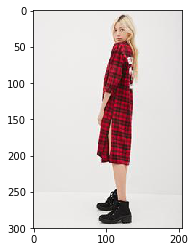

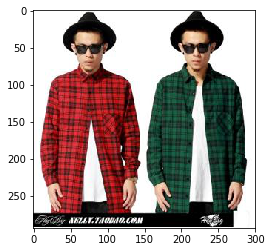

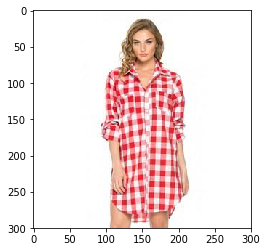

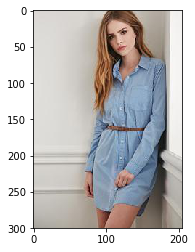

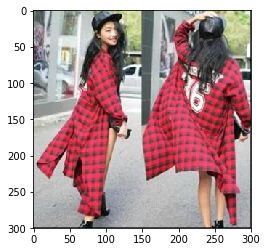

In [22]:
# lets plot some fashion

for i in range(5):
    plt.figure()
    plt.imshow(X[i])

(300, 205, 3)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Train = (pd.read_csv('data/fashion-mnist_train.csv')).values
Test  = (pd.read_csv('data/fashion-mnist_test.csv')).values

In [65]:
onlyfiles

[]